# **EXERCÍCIO PROGRAMA 2.1**

## **Alunos:**  

*   Amanda Cristina Mazer - NUSP: 10200951
*   Carlos Alberto Silva de Souza - NUSP: 8539408
*   Leonardo Miranda de Brito - NUSP: 12630364


## **GitHub do projeto + dados:**

*   Link para o GitHub: https://github.com/Giganoide01/MAC5768_EPs
*   Link para a pasta do Google Drive: https://drive.google.com/drive/u/0/folders/1WEzT7nZTrtw9EBntSM8hCzoGQyDAQUIw


## Carregamento das bibliotecas ##

In [ ]:
import skimage
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import ndimage
from time import time
from skimage import io
from skimage.transform import resize
from joblib import Parallel, delayed
import gc
from google.colab import drive
import os
import math
from random import choice
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [ ]:
t00 = time()

In [ ]:
# Coletor de lixo para otimização da memória:
gc.enable()

## Pasta do Drive ##

In [ ]:
# Montando a pasta:
drive.mount('/content/gdrive')

# Alterando o diretório:
os.chdir('/content/gdrive/My Drive/MAC5768 - EPs/')

# Listando os arquivos do diretório:
!ls

Mounted at /content/gdrive
 Anel		    EP2-1.ipynb			        Livro
 augmentedDataset   EP2-2.ipynb			        MetaDadosc.xlsx
 Caneta		    Faca			        normalizedDataset
 Chave		    Fundo_gradiente		        originalGrayDataset
'Colher de pau'     Garfo			        Prato
 Copo		    Gradientes			        Tênis
 EP1.ipynb	   'Informações padronizadas EP.gdoc'


## Metadados ##

In [ ]:
# Tabela principal:
metadados = pd.read_excel('MetaDadosc.xlsx')
%load_ext google.colab.data_table
metadados

,nome_arq,classe,numero_obj,repeticao,fundo,iluminacao
0,lvr1,6,1,1,1,2
1,lvr2,6,1,2,1,2
2,lvr3,6,1,3,1,2
3,lvr4,6,2,1,1,2
4,lvr5,6,2,2,1,2
...,...,...,...,...,...,...
3271,tns356,4,9,2,3,3
3272,tns357,4,9,3,3,3
3273,tns358,4,10,1,3,3
3274,tns359,4,10,2,3,3


In [ ]:
# Tabela com as informações das classes:
classes = pd.read_excel('MetaDadosc.xlsx', sheet_name='Classe')
classes

,codigo,descricao,abreviacao
0,1,Faca,fcs
1,2,Copo,cpo
2,3,Garfo,grf
3,4,Tênis,tns
4,5,Caneta,can
5,6,Livro,lvr
6,7,Colher de pau,cdp
7,8,Prato,prt
8,9,Chave,chv
9,10,Anel,ans


## Nota sobre paralelização de loops ##

Para maior eficiência e uso de todos os processadores disponíveis, a biblioteca joblib foi utilizada para aplicar as funções em larga escala. A implementação foi baseada no seguinte tutorial:

https://scikit-image.org/docs/stable/user_guide/tutorial_parallelization.html

## 1. RGB2gray (ie converter as imagens RGB originais em níveis de cinza)##

Breve explicação do código: converte uma imagem RGB para níveis de cinza em
8-bits por pixel. Reduz as dimensões da imagem original pela metade. Apoia-se
nas funções nativas do skimage.

Documentação da rgb2gray do skimage: https://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2gray

Documentação da resize do skimage: https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize

Documentação da img_as_ubyte do skimage: https://scikit-image.org/docs/stable/api/skimage.html#skimage.img_as_ubyte

In [ ]:
def rgbparacinza(imagem):
  '''
  (numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem RGB e a transforma para uma imagem em níveis de cinza.
  Além disso, reduz as dimensões da imagem para metade das dimensões originais
  e retorna um numpy.ndarray com 8-bits por pixel, ou seja, do tipo np.uint8.

  Dependências: skimage, skimage.transform.resize, numpy as np
  '''

  # Converte para níveis de cinza:
  im_cinza = skimage.color.rgb2gray(imagem)

  # Aplica o resize - diminuindo para metade das dimensões originais:
  im_cinza = resize(im_cinza, output_shape = (im_cinza.shape[0]//2,im_cinza.shape[1]//2), anti_aliasing = False)

  # Muda o tipo de dado para np.uint8:
  im_cinza = skimage.util.img_as_ubyte(im_cinza)

  return im_cinza

## 2. Soma de fundo com gradiente de cinza ##

Breve explicação do código: a função recebe uma imagem em níveis de cinza de dimensão n linhas por m colunas e 8-bits por pixel (range de 0 a 255). Além disso, recebe uma imagem em níveis de cinza da mesma dimensão da imagem anterior
porém com pixels no range 0 a 1. Retorna uma imagem que "soma" as duas por meio da operação OUT = INPUT_1 * INPUT_2, pixel a pixel.

In [ ]:
def soma_gradiente(imagem, fundo_gradiente):
  '''
  (numpy.ndarray,numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem (imagem) em níveis de cinza com 8-bits por pixel e uma 
  imagem (fundo_gradiente) em   níveis de cinza com o tipo de dado numpy.float64
  no range(0,1). As duas imagens possuem a mesma dimensão.

  É retornada a soma das imagens por meio da operação:
  OUTPUT = IMAGEM*FUNDO_GRADIENTE

  A imagem OUTPUT é convertida para 8-bits por pixel (no range(0,255)).

  Dependências: numpy as np, skimage.
  '''

  # Realizando a 'soma': fundo_gradiente está no range (0,1):
  out = fundo_gradiente*imagem

  # Muda o tipo de dado para np.uint8:
  out = np.array(out, dtype = np.uint8)

  return out

## 3. Logaritmo natural da imagem ##

Breve explicação do código: foi utilizada a função nativa adjust_log do skimage, que aplica a transformação OUTPUT = LN(1+INPUT). 

A documentação dessa função pode ser acessada através do link: https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.adjust_log

In [ ]:
def logaritmo_imagem(imagem):
  '''
  (numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem (imagem) em níveis de cinza com 8-bits por pixel.

  É retornada o logaritmo natural da imagem por meio da operação:

  OUTPUT = LN(1+INPUT)

  Na equação acima, INPUT é convertido internamente para o range(0,1).

  A imagem OUTPUT é convertida para 8-bits por pixel (no range(0,255)).

  Dependências: skimage, numpy as np
  '''

  # Aplica a transformação logarítmica:
  out = skimage.exposure.adjust_log(imagem)

  # Muda o tipo de dado para np.uint8:
  out = np.array(out, dtype = np.uint8)

  return out

## 4. Exponencial da imagem ##

Breve explicação do código: Essa função aplica a seguinte transformação para cada imagem de entrada:

OUT = 255 * (exp(IN/255)-1)/(e-1)

Ou seja, a escala da imagem de entrada é convertida para (0,1) por meio da 
operação:

IN = IN/255

Após isso, a exponencial foi aplicada à imagem, obtendo uma saída no range (1,e):

OUT = exp(IN)

A saída foi renormalizada para o range (0,1), por meio da operação:

OUT = (OUT-1)/(e-1)

Por fim, a saída possui novamente range (0,255), através da multiplicação por 255.

In [ ]:
def exponencial_imagem(imagem):
  '''
  (numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem (imagem) em níveis de cinza com 8-bits por pixel.

  É retornada o logaritmo natural da imagem por meio da operação:

  OUTPUT = exp(INPUT)

  Na equação acima, INPUT é convertido internamente para o range(0,1).

  A imagem OUTPUT é convertida para 8-bits por pixel (no range(0,255)).

  Dependências: numpy as np, skimage, math
  '''

  # Aplica a função OUT = 255 * (exp(IN/255)-1)/(e-1):
  out = 255*(np.exp(imagem/255, dtype = np.float64)-1)/(math.e-1)

  # Muda o tipo de dado para np.uint8:
  out = np.array(out, dtype = np.uint8)

  return out

## 5. Filtro da média usando convolução ##

Breve explicação do código: o filtro da média é aplicado a partir de convolução com um vetor de pesos (weights) de dimensões 9x9 e zero-padding. Usamos como base a função convolve do scipy.

A documentação da convolve pode ser acessada através do link: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html

In [ ]:
def filtro_media(imagem):
  '''
  (numpy.ndarray) -> numpy.ndarray
  Recebe uma imagem (imagem) em níveis de cinza com 8-bits por pixel.

  É retornado o filtro da média da imagem de entrada usando convolução,
  uma janela de dimensões 9x9 e zero-padding.

  Dependências: numpy as np, scipy.ndimage, skimage
  '''

  # Matriz de pesos ('weights'):
  k = np.full(shape = (9,9), fill_value = 1/81)

  # Aplica a convolução:
  out = ndimage.convolve(input = imagem, weights = k, mode = 'constant', cval = 0.0)

  # Muda o tipo de dado para np.uint8:
  out = np.array(out, dtype = np.uint8)

  return out

## 6. Funções gerais para aplicação dos filtros ##

As funções a seguir serão usadas tanto no EP2-1 quanto EP2-2. As mesmas realizam diversas tarefas que são comuns aos filtros, são elas:

* Criam um novo diretório (e todos os diretórios intermediários) para cada filtro que será aplicado . Verificam, também, se o diretório necessário já está criado.

* Lêem as imagens-base (colorida para o filtro 'rgbparacinza' e em escala de cinza para todos os outros filtros), aplicam o filtro e escrevem a nova imagem na pasta correspondente. O nome da imagem transformada também é relacionado com a sua transformação.

* Cronometram e imprimem ao usuário os tempos para a realização de determinada tarefa para determinada pasta.

In [ ]:
def cria_dataset(diretorio_original, tipo):
  ''' (str, str) -> None
  Essa função recebe duas strings: diretorio_original e tipo. Ela simplesmente
  cria uma pasta com o nome 'tipo' dentro de diretorio_original. Os valores que
  'tipo' irá receber são diversos: originalGrayDataset, augmentedDataset,
  normalizedDataset, os nomes das diferentes classes (Anel, Copo, etc) ou dos 
  filtros específicos (Exp, Log, Norm, Grad, Med).
  Dependência: os
  '''

  if not os.path.exists(diretorio_original + tipo):
    path = diretorio_original+tipo
    os.makedirs(path)
    

In [ ]:
diretorio_final = '/content/gdrive/My Drive/MAC5768 - EPs/'

# Criando os datasets 'originalGrayDataset' e 'augmentedDataset':
cria_dataset(diretorio_final,'originalGrayDataset' )
cria_dataset(diretorio_final,'augmentedDataset' )

In [ ]:
def aplica_filtro(tipo_filtro , diretorio_original, diretorio_final, classe, dicionario_filtros = filtros):
  ''' (function, str, str, str,dict) -> None.
  Essa função é o coração do EP. A mesma recebe uma função de filtro ('tipo_filtro')
  e aplica a mesma para todas as imagens da classe 'classe' que estiverem na 
  pasta 'diretorio_original', escrevendo-as na pasta 'diretorio_final'. 

  No ato de aplicar os filtros, essa função utiliza o dicionário 'dicionario_filtros'
  para criar pastas com os nomes das transformações dentro das pastas das classes
  no 'diretorio_final', além de escrever as extensões corretas no nome final.

  No caso da transformação em níveis de cinza, não foi criada uma nova pasta nos
  diretórios de classes por ser considerada supérflua.

  Exemplo de aplicação 1:
  >>> aplica_filtro(tipo_filtro = rgbparacinza,
  diretorio_original = '/content/gdrive/MyDrive/MAC5768 - EPs/',
  diretorio_final = '/content/gdrive/MyDrive/MAC5768 - EPs/originalGrayDataset/',
  classe = 'Anel')
  #Lê todas as imagens que estiverem na pasta '/content/gdrive/MyDrive/MAC5768 - EPs/Anel'
  #Aplica a transformação rgbparacinza em cada imagem com nome, por ex., 'exemplo.jpg'
  #Acessa a chave correspondente a rgbparacinza em dicionario_filtros (padrão: 'cin')
  #Escreve a imagem transformada na pasta '/content/gdrive/MyDrive/MAC5768 - EPs/originalGrayDataset/Anel'
  #Com o nome 'exemplo-cin.jpg'

  Exemplo de aplicação 2:
  >>> aplica_filtro(tipo_filtro = logaritmo_imagem,
  diretorio_original = '/content/gdrive/MyDrive/MAC5768 - EPs/originalGrayDataset/',
  diretorio_final = '/content/gdrive/MyDrive/MAC5768 - EPs/augmentedDataset/',
  classe = 'Anel')
  #Lê todas as imagens que estiverem na pasta '/content/gdrive/MyDrive/MAC5768 - EPs/originalGrayDataset/Anel/'
  #Aplica a transformação logaritmo_imagem em cada imagem com nome, por ex., 'exemplo-cin.jpg'
  #Acessa a chave correspondente a logaritmo_imagem em dicionario_filtros (padrão: 'log')
  #Escreve a imagem transformada na pasta '/content/gdrive/MyDrive/MAC5768 - EPs/augmentedDataset/Anel/log/'
  #Com o nome 'exemplo-cin-log.jpg'

  Dependências: gc, time.time, from pathlib import Path, skimage.io, os, skimage, random.choice
  '''

  # Correção para a entrada 'faca' em vez de 'Faca':
  classe = classe.capitalize()

  # Coletor automático de lixo:
  gc.enable()

  # Tempo para aplicação da função:
  t0 = time()

  # Transformando a string do diretório de entrada em um objeto Path:
  folder_entrada = Path(f"{diretorio_original}/{classe}/")

  # Extensão dos arquivos e nomes das novas pastas:
  extensao = dicionario_filtros[tipo_filtro]

  # Criando e nomeando a nova pasta:
  if tipo_filtro != rgbparacinza:
    cria_dataset(diretorio_final, f"{classe}/{extensao}/")
    nova_pasta = Path(f"{diretorio_final}/{classe}/{extensao}/")
  else:
    # Se a transformação for para níveis de cinza, não é necessário usar a extensão
    cria_dataset(diretorio_final, f"/{classe}")
    nova_pasta = Path(f"{diretorio_final}/{classe}/")

  # Listando as imagens na pasta original:
  nomes_imagens = os.listdir(folder_entrada)

  # Fazendo a lista das imagens gradiente, caso o filtro seja gradiente:
  if tipo_filtro == soma_gradiente:
    pasta_gradientes = Path("/content/gdrive/My Drive/MAC5768 - EPs/Gradientes/")
    # Lista o nome das imagens gradiente:
    nomes_gradientes = list(os.listdir(pasta_gradientes))

  for nome_imagem in nomes_imagens:
    # Lendo a imagem de entrada:
    imagem_entrada = io.imread(f"{folder_entrada}/{nome_imagem}")

    # Aplicando o filtro:
    if tipo_filtro == soma_gradiente:

      # Escolhendo um fundo gradiente aleatório:
      gradiente = io.imread(f"{pasta_gradientes}/{choice(nomes_gradientes)}")
      # Ajustando o tamanho dele para a imagem de entrada:
      gradiente = skimage.transform.resize(gradiente, output_shape= imagem_entrada.shape)

      imagem_saida = tipo_filtro(imagem_entrada, gradiente)

    else:
      imagem_saida = tipo_filtro(imagem_entrada)

    # Escrevendo a imagem de saída no diretório correto com a extensão correta:
    os.chdir(nova_pasta)
    io.imsave(f"{nome_imagem[:-4]}-{extensao}.jpg", imagem_saida)

    del imagem_entrada, imagem_saida

  del nomes_imagens

  # Tempo para aplicação da função:
  t1 = time()
  print(f"Tempo para aplicação do filtro '{extensao}' para a pasta {folder_entrada}: {(t1-t0):.3f}s")

In [ ]:
# Lista de filtros:
lista_filtros = [soma_gradiente, logaritmo_imagem, exponencial_imagem, filtro_media]

# Dicionário de funções que relaciona o filtro aplicado ao nome da pasta
# correspondente e à extensão do arquivo transformado:
filtros = {rgbparacinza: 'cin', soma_gradiente: 'grad', logaritmo_imagem:'log',
           exponencial_imagem: 'exp', filtro_media:'med'}

In [ ]:
# Aplicando a transformação para níveis de cinza:
Parallel(n_jobs=-1, verbose = 1)(delayed(aplica_filtro)(tipo_filtro = rgbparacinza, diretorio_original = diretorio_final, diretorio_final = f"{diretorio_final}/originalGrayDataset/",classe = classe) for classe in classes['descricao'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 17.7min finished


[None, None, None, None, None, None, None, None, None, None]

In [ ]:
# Aplicando as demais transformações (EP FINAL):
for filtro in lista_filtros:
  Parallel(n_jobs=-1, verbose = 1)(delayed(aplica_filtro)(tipo_filtro = filtro, diretorio_original = f"{diretorio_final}/originalGrayDataset/", diretorio_final = f"{diretorio_final}/augmentedDataset/" , classe = classe) for classe in classes['descricao'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 19.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 18.7min finished


## Tempo de execução do notebook ##

In [ ]:
t11 = time()
tempo_em_horas = (t11-t00)//3600
sobra = (t11-t00)%3600
tempo_em_minutos = sobra//60
tempo_em_segundos = sobra%60
print(f"Tempo de execução do notebook: {tempo_em_horas} h {tempo_em_minutos} min {tempo_em_segundos} s")

Tempo de execução do notebook: 1.0 h 11.0 min 16.008258819580078 s


## 7. Visualização do augmentedDataset ##
Para visualização dos resultados do augmentedDataset, de como os filtros descritos e implementados influenciaram na transformação das imagens, um exemplo de cada classe foi aleatoriamente selecionado e mostrado a seguir através de um MNIST-LIKE.

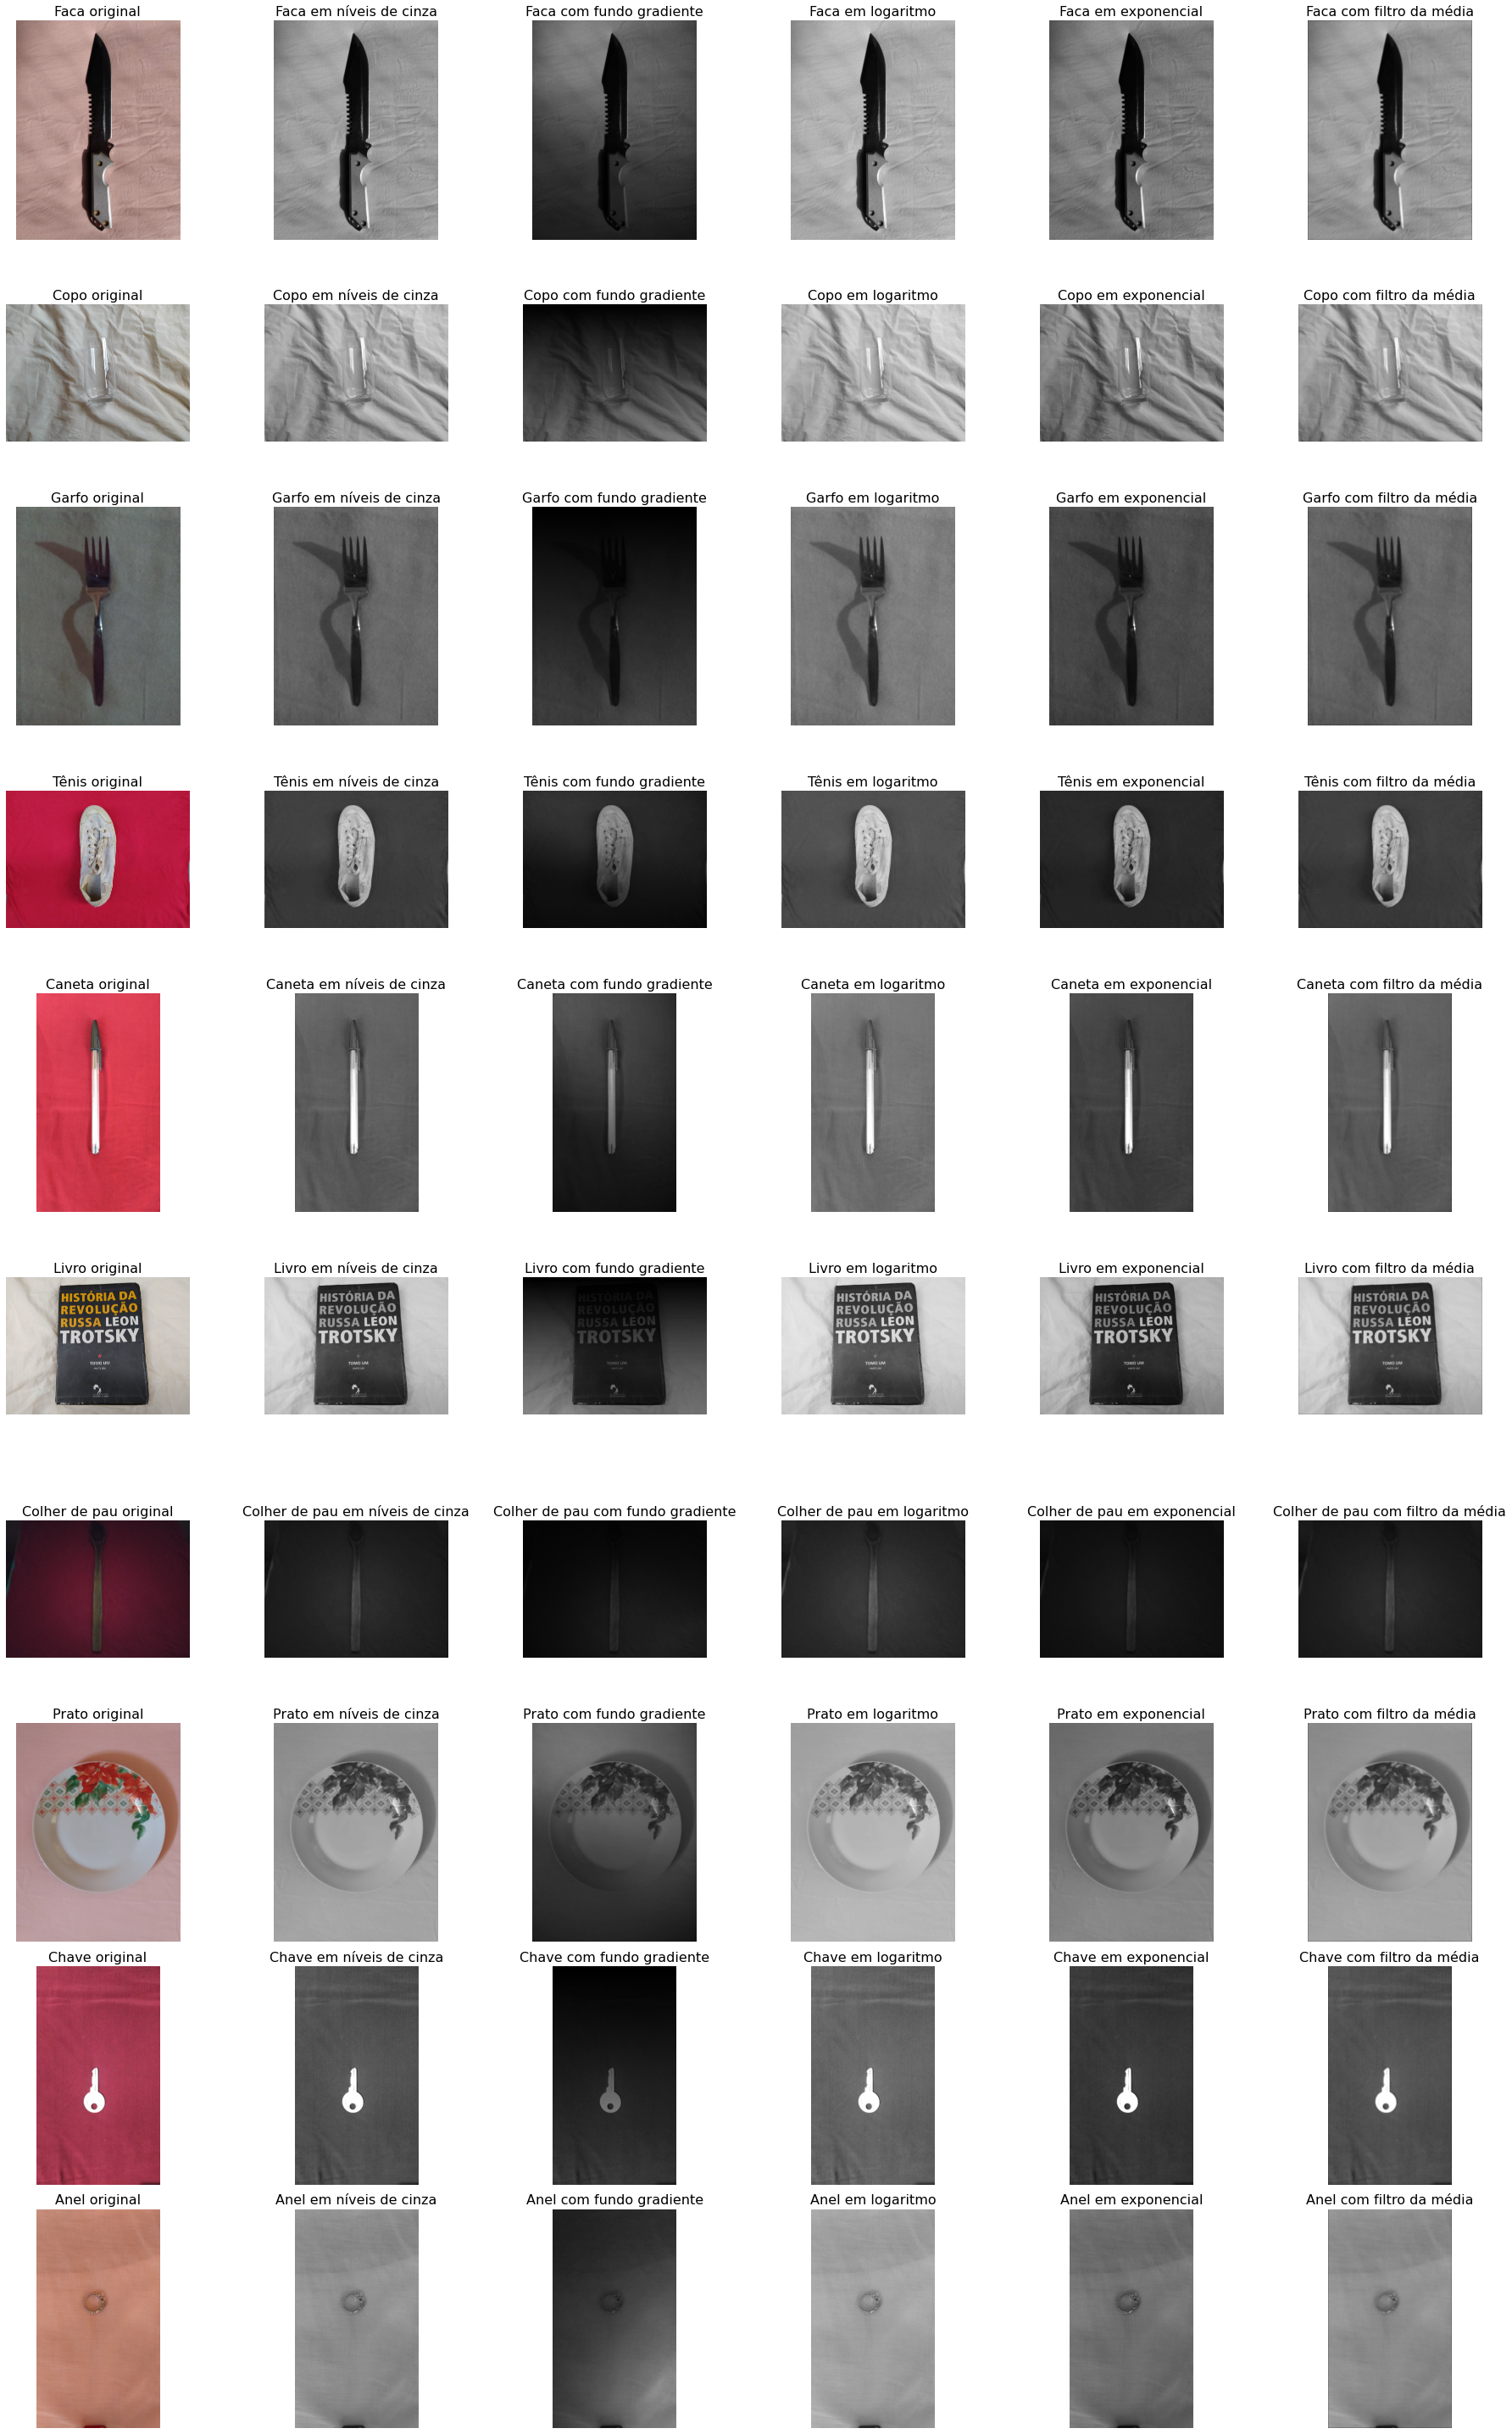

In [ ]:
diretorio_final = '/content/gdrive/My Drive/MAC5768 - EPs/'
lista_extensoes = ['grad', 'log', 'exp', 'med']
classes = pd.read_excel('MetaDadosc.xlsx', sheet_name='Classe')

# Sorteando e lendo uma imagem de cada classe com todos os filtros:
imagens = {}
for i in range(classes.shape[0]):
  classe = classes.iloc[i]['descricao']
  nome_imagem = random.sample(os.listdir(diretorio_final + 'originalGrayDataset/' + classe), 1)[0]
  imagens[classe] = [io.imread(diretorio_final + classe + '/' + nome_imagem[:nome_imagem.index("-")] + '.jpg'), io.imread(diretorio_final + 'originalGrayDataset/' + classe + '/' + nome_imagem)]
  for ext in lista_extensoes:
    imagens[classe].append(io.imread(diretorio_final + 'augmentedDataset/' + classe + '/' + ext + '/' + nome_imagem[:nome_imagem.index(".")] + '-' + ext + '.jpg'))

# Plot:
titulos = [" original", " em níveis de cinza", " com fundo gradiente", " em logaritmo", " em exponencial", " com filtro da média"]

fig, axs = plt.subplots(classes.shape[0], len(titulos), figsize=(25, 40))
for i in range(classes.shape[0]):
  classe = classes.iloc[i]['descricao']
  for j in range(len(titulos)):
    if j == 0:
      axs[i,j].imshow(imagens[classe][j])
    else:
      axs[i,j].imshow(imagens[classe][j], cmap='gray', vmin=0, vmax=255)
    axs[i,j].set_title(classe + titulos[j], fontsize=16)
    axs[i,j].axis('off')
plt.tight_layout()
plt.show()


## 8. Tabela global sumária ##

Uma versão ligeiramente modificada da função do EP1 foi utilizada para obter algumas medidas em resumo, dos dados do originalGrayDataset + augmentedDataset.

In [ ]:
descricao_tgs = ['Número de classes', 'Número de imagens', 'Tamanho da base (MB)']
valores_tgs = [classes.shape[0], 5*3276] # Número total de classes e número total de amostras

diretorio = '/content/gdrive/My Drive/MAC5768 - EPs/originalGrayDataset/'
classes_descr = []
for i in range(classes.shape[0]): # Criação dos atributos da tabela global sumária
  classe = classes.iloc[i]['descricao']
  classes_descr.append(classe)
  abreviacao = classes.iloc[i]['abreviacao'] 
  im = io.imread(diretorio + classe + '/' + abreviacao + str(i+1) +  '-cin'+ '.jpg') 
  descricao_tgs.append('Resolução imagens de ' + classe)
  valores_tgs.append(str(im.shape[0]) + ' x ' + str(im.shape[1]))  # Resolução

tamanho = 0
for root, dirs, files in os.walk('/content/gdrive/My Drive/MAC5768 - EPs/originalGrayDataset'):
  tamanho += sum([os.path.getsize(os.path.join(root,name)) for name in files])
for root, dirs, files in os.walk('/content/gdrive/My Drive/MAC5768 - EPs/augmentedDataset'):
  tamanho += sum([os.path.getsize(os.path.join(root,name)) for name in files])

valores_tgs.insert(2, round(tamanho/(10**6)))  # Tamanho da base em MB

# Tabela global sumária:
tgs = pd.DataFrame(list(zip(descricao_tgs, valores_tgs)), columns = ['Descrição', 'Valor'])
tgs.set_index('Descrição')

,Valor
Descrição,
Número de classes,10
Número de imagens,16380
Tamanho da base (MB),2957
Resolução imagens de Faca,1632 x 1224
Resolução imagens de Copo,1500 x 2000
Resolução imagens de Garfo,1632 x 1224
Resolução imagens de Tênis,1500 x 2000
Resolução imagens de Caneta,1632 x 918
Resolução imagens de Livro,1500 x 2000
